(demes_vignette)=

# Using `demes` to specify demographic models.

:::{note}
The lists of objects described here are passed to the `demography` and `simlen` parameters when initializing instances of {class}`fwdpy11.ModelParams`.
:::

Starting with version `0.14.0`, it is possible to specify a demographic model using the [`demes`](https://popsim-consortium.github.io/demes-docs/main/) specification.
This method of specifying models uses a `YAML` syntax, which is described in detail in the [`demes specification`](https://popsim-consortium.github.io/demes-spec-docs/main/reference.html).

It is a good idea to browse both the [tutorial](https://popsim-consortium.github.io/demes-spec-docs/main/tutorial.html) and the [gallery](https://popsim-consortium.github.io/demes-spec-docs/main/gallery.html#sec-gallery) before continuing.

There are several advantages to using `demes`:

* The `YAML` files can be used by many pieces of related software, including [`msprime`](https://tskit.dev/msprime/docs/stable/) and [`moments`](https://moments.readthedocs.io).
* You'll get an extra layer of model validation when `demes` loads your model prior to it being converted into `fwpdy11` objects.
* Tools to visualize the models are under active development.

## YAML input

The following `YAML` specifies a model of a derived population created
from unequal admixture of two ancestral populations 50 generations ago:

In [1]:
yaml="""
description: An example demes model
time_units: generations
demes:
 - name: ancestor1
   epochs:
    - start_size: 100
      end_time: 50
 - name: ancestor2
   epochs:
    - start_size: 250
      end_time: 50
 - name: admixed
   start_time: 50
   ancestors: [ancestor1, ancestor2]
   proportions: [0.90, 0.10]
   epochs:
    - start_size: 100
"""

A visual representation of the model looks like:

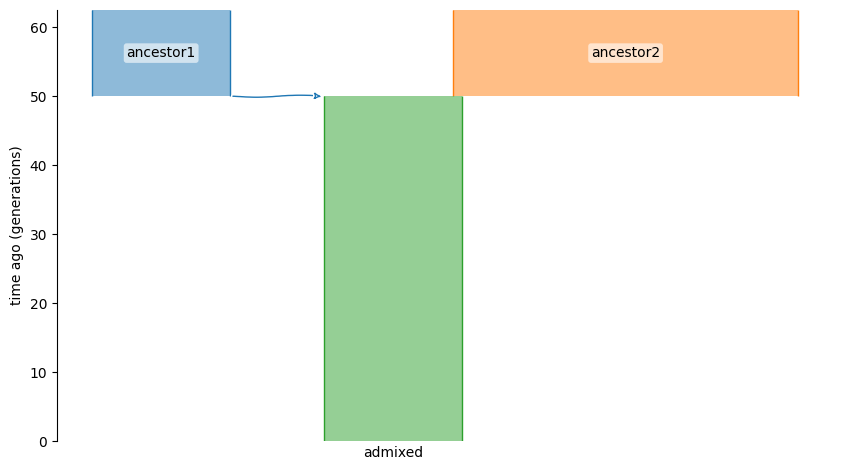

In [2]:
import demes
import demesdraw
graph = demes.loads(yaml)
demesdraw.tubes(graph);

We can generate demographic models directly from these `YAML` files using
{func}`fwdpy11.ForwardDemesGraph.from_demes`.

In [3]:
import fwdpy11

demography = fwdpy11.ForwardDemesGraph.from_demes(yaml, burnin=100, burnin_is_exact=True)

The previous command defines a model where we evolve the population for 100 generations
of a "burn-in".
When `burnin_is_exact=False`, the value passed to `burnin` is treated as a multiple
of the **sum** of all ancestral deme sizes (those having a start time of `inf`
in the demes model).

:::{note}
Be sure to read the documentation for {func}`fwdpy11.ForwardDemesGraph.from_demes`!
There are important options concerning the run time of the simulation, etc.
:::

The return value is an instance of {class}`fwdpy11.ForwardDemesGraph`.
The object contains several properties that are useful in setting up your
simulation.

First, the sizes of all demes extant at generation zero:

In [4]:
demography.initial_sizes

[100, 250]

This property can be used to correctly initialize a population:

In [5]:
pop = fwdpy11.DiploidPopulation(demography.initial_sizes, 1000.)
print(pop.deme_sizes())

(array([0, 1], dtype=int32), array([100, 250]))


The generation corresponding to the end of the model:

In [6]:
demography.final_generation

150

We can now set up our simulation parameters:

In [7]:
pdict = {'simlen': demography.final_generation,
         'demography': demography,
         # Everything below is standard
         # and covered in other vignettes
         'recregions': [],
         'nregions': [],
         'sregions': [],
         'rates': (0,0,0),
         'gvalue': fwdpy11.Multiplicative(2.)
         }
params = fwdpy11.ModelParams(**pdict)

We are now ready to run a simulaton:

* We have a valid {class}`fwdpy11.ModelParams` object.
* Our population has its initial sizes correctly set.

## Obtaining the demes present at the end of a simulation

In [8]:
demography.demes_at_final_generation

[2]

To get the names of those demes:

In [9]:
for deme in demography.demes_at_final_generation:
    print(demography.deme_labels[deme])

admixed


It is probably useful to read more about how ``fwdpy11`` handles ``demes``
models {ref}`here <demes_details>`.